# Домашнее задание ШАД МТС по теме ТВиМС 4

## Задание

Необходимо подготовить отчет с результатами применения обсужденных на лекции методов к произвольным данным, которые вы найдете в свободном доступе.

1. На платформе Kaggle или на Github найдите достаточно большой датасет с логами пользования сервисов (просмотры Youtube или стриминговых сервисов, такси/каршеринг или что угодно, где есть много юзеров и история их взаимодействия с каким-нибудь сервисом). В случае, если такого датасета нет - сгенерируйте самостоятельно (например, как на лекции было показано распределение по просмотру в Кион).
2. Разбейте на сегменты вашу аудиторию и примените для нескольких (примерно 3-4 метрики) метрик тесты Стьюдента, Манна-Уитни, Фишера (Фишера для нескольких сегментов). Проинтерпретируйте результаты, сделайте первые выводы.
3. Для >=3 сегментов сделайте попарные сравнения через тест Стьюдента и тест Фишера. Проверьте соотносятся ли результаты.
4. Постройте точный и эфронов доверительные интервал для выбранных метрик. Проверьте соответствуют ли эти доверительные интервалы результатам теста Стьюдента.
5. Подумайте, можно ли использовать в пункте 2 другие стат. тесты. Приведите пару примеров.

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from icecream import ic
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

alpha = 0.05 # зададимся уровнем значимости

### Загрузка и извлечение данных из выбранного датасета

Источником данных для текущей работы будет [Adult dataset](http://www.cs.toronto.edu/~delve/data/adult/desc.html)

In [2]:
# Загружаем данные

df = pd.read_csv('./datasets/adult.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
# Для удобства, создадим списки признаков

# Числовые признаки
num_cols = [
    'age',
    'fnlwgt',
    'educational-num',
    'capital-gain',
    'capital-loss',
    'hours-per-week'
]

# Категориальные признаки
cat_cols = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'gender',
    'native-country'
]

feature_cols = num_cols + cat_cols
target_col = 'income'

In [4]:
# Можно заметить, что некоторые значения в столбцам категориальных признаков пропущены и равны '?'. Посмотрим, сколько таких строк

df[(df[cat_cols] == '?').any(axis=1)]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
13,58,?,299831,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,35,United-States,<=50K
19,40,Private,85019,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,45,?,>50K
22,72,?,132015,7th-8th,4,Divorced,?,Not-in-family,White,Female,0,0,6,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48811,35,?,320084,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
48812,30,?,33811,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
48820,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
48822,41,?,202822,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [5]:
# Пропусков не так много, для нашей задачи их можно удалить

df.drop(df[(df[cat_cols] == '?').any(axis=1)].index, inplace=True)

***
### Сегментирование и тесты Стьюдента, Манна-Уитни, Фишера для нескольких метрик

In [6]:
# Разделим пользователей по признаку семейного положения

df['relationship'].unique()

array(['Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative'], dtype=object)

In [7]:
# Выберем все категории, за исключением сомнительного 'Other-relative'

relationships = df['relationship'].unique()[:-1]

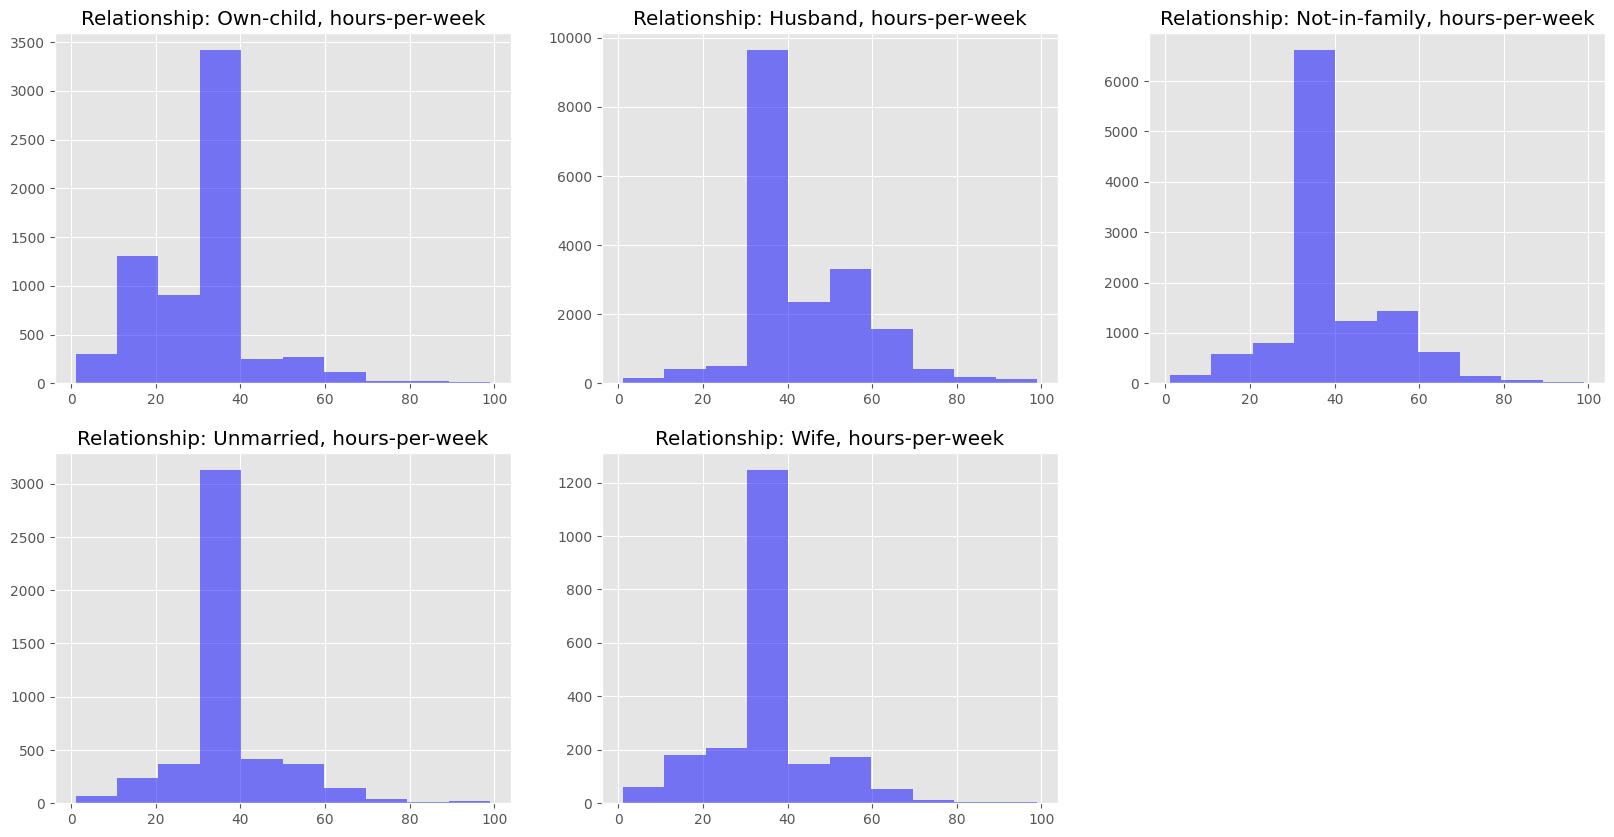

In [8]:
# Посмотрим на распределения непрерывных значений
# hours-per-week - количество рабочих часов в неделю

plt.figure(figsize=(20,10))

for i, rel in enumerate(relationships):
    plt.subplot(2, 3, i+1)
    plt.hist(df.loc[df['relationship'] == rel]['hours-per-week'],
             density=False, histtype='stepfilled', alpha=0.5, color='blue')
    plt.title(f'Relationship: {rel}, hours-per-week')

Рассматриваемые выборки имеют распределения с ярко выраженным выбросом посередине. Отмечаем осторожность в применении теста Стьюдента, будем сравнивать полученные им результаты с результатами других тестов.

Перед выполнением тестов фиксируем гипотезы:
- H0: средние значения выборок равны,
- H1: средние значения выборок отличаются

In [9]:
# Выполним раздение на сегменты

rel_husband = df.loc[df['relationship'] == 'Husband']['hours-per-week']
rel_wife = df.loc[df['relationship'] == 'Wife']['hours-per-week']
rel_unmarried = df.loc[df['relationship'] == 'Unmarried']['hours-per-week']
rel_not_in_family = df.loc[df['relationship'] == 'Not-in-family']['hours-per-week']
rel_own_child = df.loc[df['relationship'] == 'Own-child']['hours-per-week']

ic(rel_husband.mean())
ic(rel_wife.mean())
ic(rel_unmarried.mean())
ic(rel_not_in_family.mean())
ic(rel_own_child.mean());

ic| rel_husband.mean(): 44.61068252437587
ic| rel_wife.mean(): 37.47776183644189
ic| rel_unmarried.mean(): 39.44256474519632
ic| rel_not_in_family.mean(): 41.03956588617331
ic| rel_own_child.mean(): 33.32085722909749


In [10]:
# Для нескольких сегментов выполним тест Стьюдента

pvalue = st.ttest_ind(rel_husband, rel_wife).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Средние количества рабочих часов в неделю для выборок Husband и Wife, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Средние количества рабочих часов в неделю для выборок Husband и Wife, вероятно, отличаются\n')

pvalue = st.ttest_ind(rel_unmarried, rel_not_in_family).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Средние количества рабочих часов в неделю для выборок Unmarried и Not-in-family, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Средние количества рабочих часов в неделю для выборок Unmarried и Not-in-family, вероятно, отличаются')

pvalue = 1.1488017725758044e-161
Отклоняем нулевую гипотезу. Средние количества рабочих часов в неделю для выборок Husband и Wife, вероятно, отличаются

pvalue = 1.9576715415620186e-17
Отклоняем нулевую гипотезу. Средние количества рабочих часов в неделю для выборок Unmarried и Not-in-family, вероятно, отличаются


Для этих же пар выполним тест Манна-Уитни - непараметрический аналог теста Стьюдента.
Зафиксируем гипотезы:
- H0: Распределения одинаковы,
- H1: Распределения различаются

In [11]:
# Тест Манна-Уитни

pvalue = st.mannwhitneyu(rel_husband, rel_wife).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Распределения количества рабочих часов в неделю для выборок Husband и Wife, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Распределения количества рабочих часов в неделю для выборок Husband и Wife, вероятно, отличаются\n')

pvalue = st.mannwhitneyu(rel_unmarried, rel_not_in_family).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Распределения количества рабочих часов в неделю для выборок Unmarried и Not-in-family, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Распределения количества рабочих часов в неделю для выборок Unmarried и Not-in-family, вероятно, отличаются')

pvalue = 5.819082591445793e-190
Отклоняем нулевую гипотезу. Распределения количества рабочих часов в неделю для выборок Husband и Wife, вероятно, отличаются

pvalue = 6.253275667776445e-30
Отклоняем нулевую гипотезу. Распределения количества рабочих часов в неделю для выборок Unmarried и Not-in-family, вероятно, отличаются


In [12]:
# Тест Фишера для нескольких сегментов

n = 2000
pvalue = st.f_oneway(rel_husband.sample(n), rel_wife.sample(n), rel_unmarried.sample(n), rel_not_in_family.sample(n), rel_own_child.sample(n)).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу о равенстве средних')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу о равенстве средних')

pvalue = 3.377072264863788e-228
Отклоняем нулевую гипотезу о равенстве средних


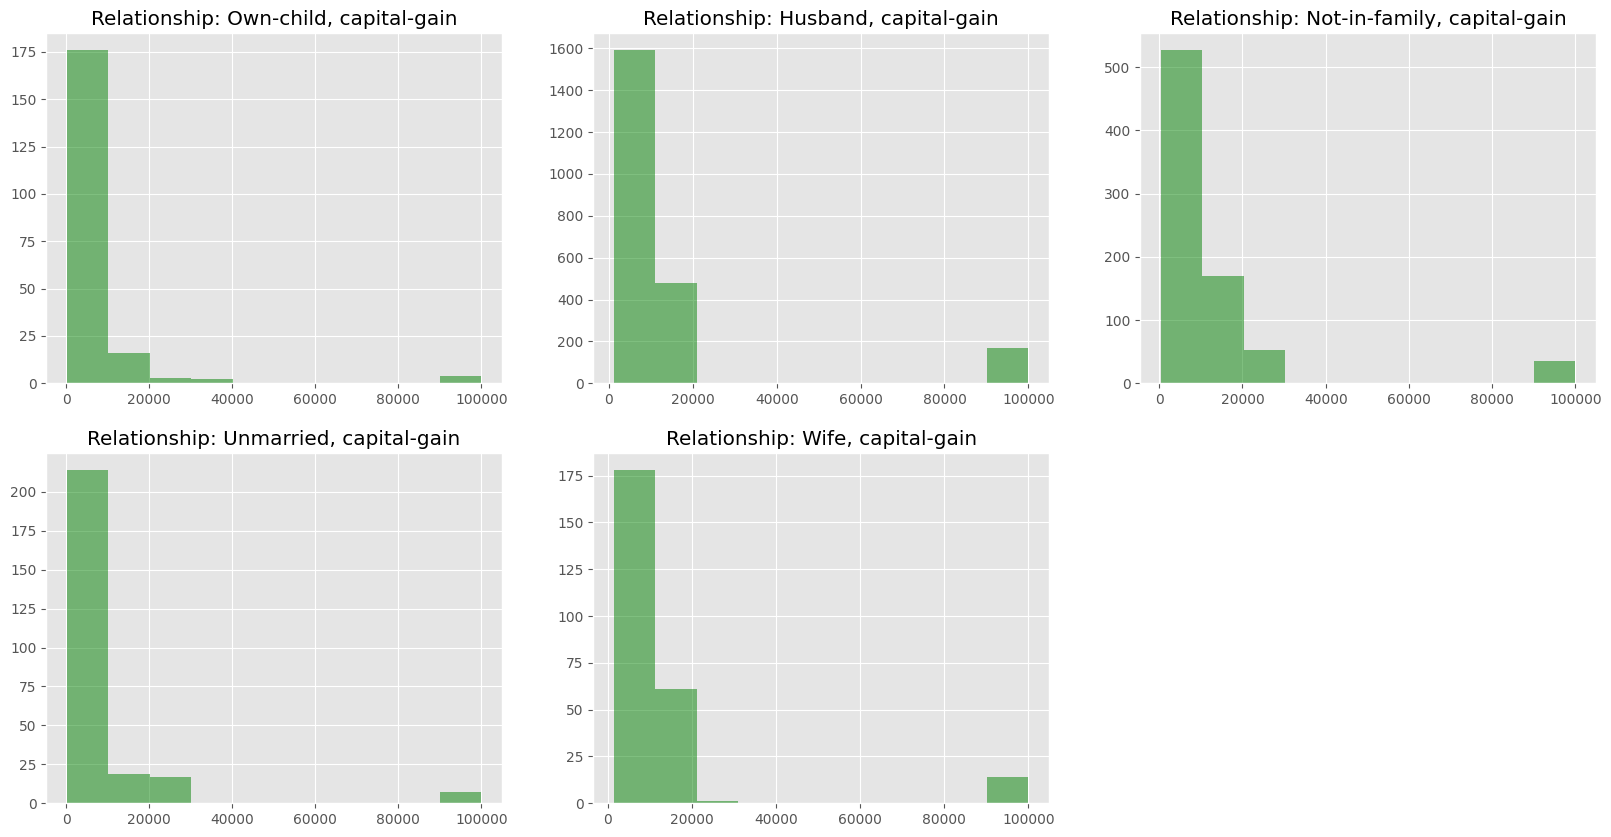

In [13]:
# Аналогично проанализируем две другие метрики:
# capital-gain - доход от инвестиционных источников (отличных от заработной платы)
# capital-loss - инвестиционные потери
# ВАЖНО! Оценивать будем среди тех людей, которые имеют доход или потери

df_capital_gain = df.loc[df['capital-gain'] != 0]

plt.figure(figsize=(20,10))

for i, rel in enumerate(relationships):
    plt.subplot(2, 3, i+1)
    plt.hist(df_capital_gain.loc[df_capital_gain['relationship'] == rel]['capital-gain'],
             density=False, histtype='stepfilled', alpha=0.5, color='green')
    plt.title(f'Relationship: {rel}, capital-gain')

In [14]:
# Проведем тесты для распределения метрики capital-gain

rel_husband = df_capital_gain.loc[df_capital_gain['relationship'] == 'Husband']['capital-gain']
rel_wife = df_capital_gain.loc[df_capital_gain['relationship'] == 'Wife']['capital-gain']
rel_unmarried = df_capital_gain.loc[df_capital_gain['relationship'] == 'Unmarried']['capital-gain']
rel_not_in_family = df_capital_gain.loc[df_capital_gain['relationship'] == 'Not-in-family']['capital-gain']
rel_own_child = df_capital_gain.loc[df_capital_gain['relationship'] == 'Own-child']['capital-gain']

ic(rel_husband.mean())
ic(rel_wife.mean())
ic(rel_unmarried.mean())
ic(rel_not_in_family.mean())
ic(rel_own_child.mean())

# Для нескольких сегментов выполним тест Стьюдента

print('\nТест Стьюдента для выборок Husband и Wife')
pvalue = st.ttest_ind(rel_husband, rel_wife).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Husband и Wife, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Husband и Wife, вероятно, отличаются\n')

print('\nТест Стьюдента для выборок Unmarried и Not-in-family')
pvalue = st.ttest_ind(rel_unmarried, rel_not_in_family).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, отличаются')

# Тест Манна-Уитни

print('\nТест Манна-Уитни для выборок Husband и Wife')
pvalue = st.mannwhitneyu(rel_husband, rel_wife).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Husband и Wife, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Husband и Wife, вероятно, отличаются\n')

print('\nТест Манна-Уитни для выборок Unmarried и Not-in-family')
pvalue = st.mannwhitneyu(rel_unmarried, rel_not_in_family).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, отличаются')

ic| rel_husband.mean(): 14793.843889384478
ic| rel_wife.mean(): 13147.476377952757
ic| rel_unmarried.mean(): 8791.210116731518
ic| rel_not_in_family.mean(): 12079.853875476492
ic| rel_own_child.mean(): 6204.910447761194



Тест Стьюдента для выборок Husband и Wife
pvalue = 0.3076864926511159
Не отклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Husband и Wife, вероятно, равны

Тест Стьюдента для выборок Unmarried и Not-in-family
pvalue = 0.019316000490928777
Отклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, отличаются

Тест Манна-Уитни для выборок Husband и Wife
pvalue = 0.8226597359591824
Не отклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Husband и Wife, вероятно, равны

Тест Манна-Уитни для выборок Unmarried и Not-in-family
pvalue = 7.263462321427706e-06
Отклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, отличаются


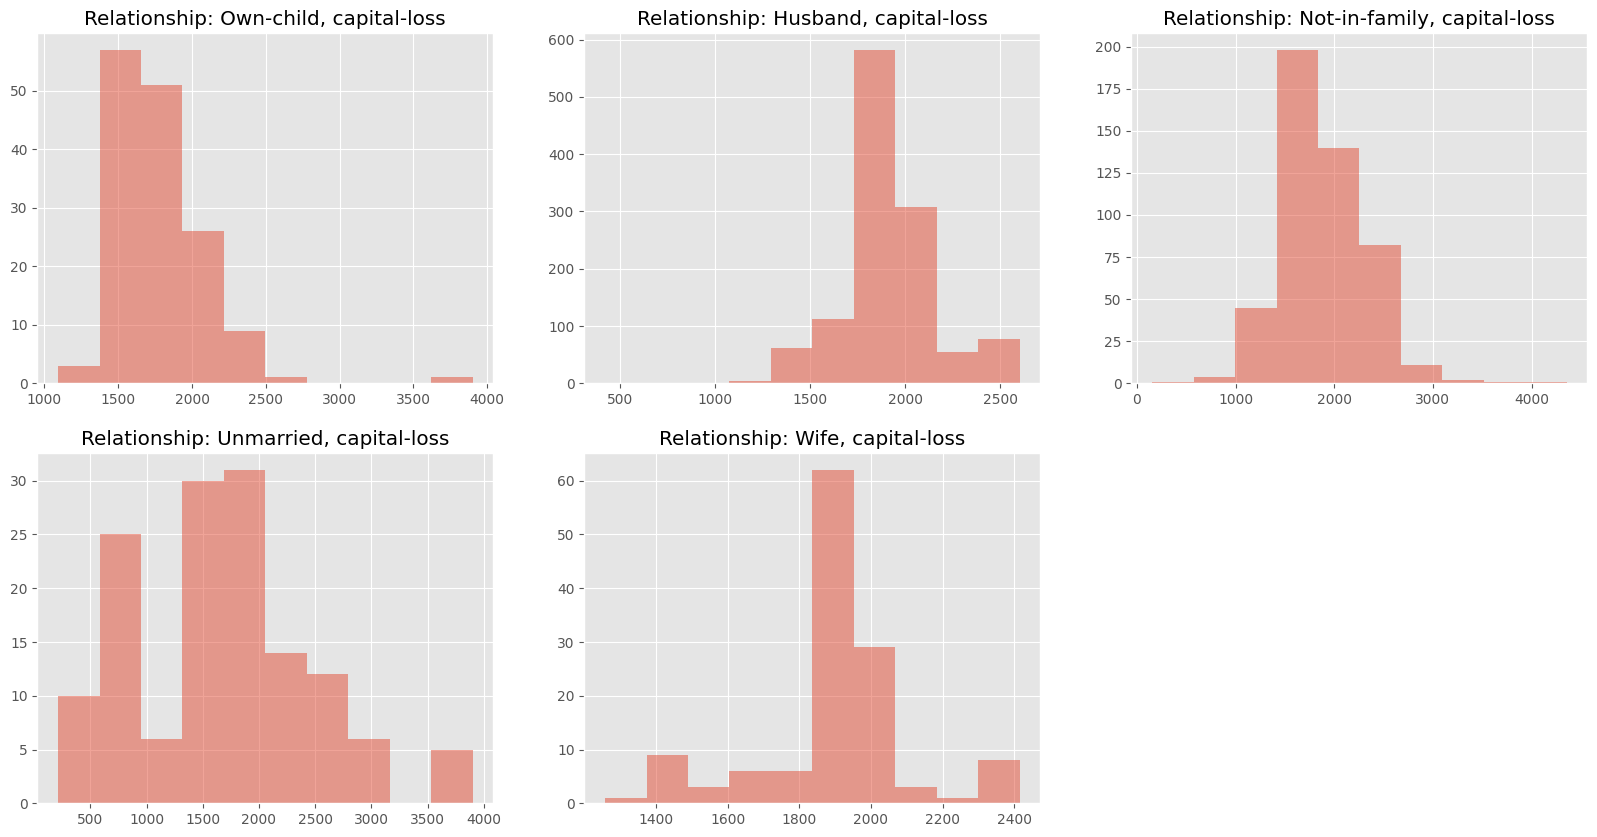

In [15]:
# Аналогично для capital-loss

df_capital_loss = df.loc[df['capital-loss'] != 0]

plt.figure(figsize=(20,10))

for i, rel in enumerate(relationships):
    plt.subplot(2, 3, i+1)
    plt.hist(df_capital_loss.loc[df_capital_loss['relationship'] == rel]['capital-loss'],
             density=False, histtype='stepfilled', alpha=0.5)
    plt.title(f'Relationship: {rel}, capital-loss')

In [16]:
# Тесты для распределения capital-loss

rel_husband = df_capital_loss.loc[df_capital_loss['relationship'] == 'Husband']['capital-loss']
rel_wife = df_capital_loss.loc[df_capital_loss['relationship'] == 'Wife']['capital-loss']
rel_unmarried = df_capital_loss.loc[df_capital_loss['relationship'] == 'Unmarried']['capital-loss']
rel_not_in_family = df_capital_loss.loc[df_capital_loss['relationship'] == 'Not-in-family']['capital-loss']
rel_own_child = df_capital_loss.loc[df_capital_loss['relationship'] == 'Own-child']['capital-loss']

ic(rel_husband.mean())
ic(rel_wife.mean())
ic(rel_unmarried.mean())
ic(rel_not_in_family.mean())
ic(rel_own_child.mean())

# Для нескольких сегментов выполним тест Стьюдента

print('\nТест Стьюдента для выборок Husband и Wife')
pvalue = st.ttest_ind(rel_husband, rel_wife).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Husband и Wife, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Husband и Wife, вероятно, отличаются\n')

print('\nТест Стьюдента для выборок Unmarried и Not-in-family')
pvalue = st.ttest_ind(rel_unmarried, rel_not_in_family).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, отличаются')

# Тест Манна-Уитни

print('\nТест Манна-Уитни для выборок Husband и Wife')
pvalue = st.mannwhitneyu(rel_husband, rel_wife).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Husband и Wife, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Husband и Wife, вероятно, отличаются\n')

print('\nТест Манна-Уитни для выборок Unmarried и Not-in-family')
pvalue = st.mannwhitneyu(rel_unmarried, rel_not_in_family).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, равны')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, отличаются')

ic| rel_husband.mean(): 1912.9376558603492
ic| rel_wife.mean(): 1896.5859375
ic| rel_unmarried.mean(): 1626.2446043165467
ic| rel_not_in_family.mean(): 1860.1958762886597
ic| rel_own_child.mean(): 1773.3175675675675



Тест Стьюдента для выборок Husband и Wife
pvalue = 0.4173613085182616
Не отклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Husband и Wife, вероятно, равны

Тест Стьюдента для выборок Unmarried и Not-in-family
pvalue = 5.641257825718524e-06
Отклоняем нулевую гипотезу. Средние значения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, отличаются

Тест Манна-Уитни для выборок Husband и Wife
pvalue = 0.674026844943804
Не отклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Husband и Wife, вероятно, равны

Тест Манна-Уитни для выборок Unmarried и Not-in-family
pvalue = 0.00036481854936168753
Отклоняем нулевую гипотезу. Распределения инвестиционных доходов для выборок Unmarried и Not-in-family, вероятно, отличаются


In [17]:
# Тест Фишера для нескольких сегментов

pvalue = st.f_oneway(rel_husband, rel_wife, rel_unmarried, rel_not_in_family, rel_own_child).pvalue
if pvalue > alpha:
    print(f'pvalue = {pvalue}\nНе отклоняем нулевую гипотезу о равенстве средних')
else:
    print(f'pvalue = {pvalue}\nОтклоняем нулевую гипотезу о равенстве средних')

pvalue = 2.912767474823311e-20
Отклоняем нулевую гипотезу о равенстве средних


**Предварительные выводы:** В рамках данного пункта были проанализированы следующие метрики:
- hours-per-week - количество рабочих часов в неделю,
- capital-gain - инвестиционные доходы,
- capital-loss - инвестиционные потери

для следующих интуитивно близких категорий:
- Husband,
- Wife,
- Unmarried,
- Not-in-family.

В результате проведенных тестов было выявлено равенство средних в распределениях инвестиционных доходов и потерь для категорий Husband и Wife.

Несмотря на отсутствие нормального распределения укзаанных метрик, значения подтверждены тестами Стьюдента и Манна-Уитни.

Для остальных групп и метрик нулевая гипотеза была отвергнута.
***

### Попарные сравнения через тест Стьюдента и тест Фишера

Попарные сравнения через тест Стьюдента и тест Фишера будем выполнять для метрики capital-loss

In [18]:
# Так как размеры выборок сильно отличаются, выровняем их

n = min(rel_husband.shape[0], rel_wife.shape[0], rel_own_child.shape[0], rel_unmarried.shape[0], rel_not_in_family.shape[0])

groups = {'Husband': rel_husband.sample(n),
          'Wife': rel_wife.sample(n),
          'Unmarried': rel_unmarried.sample(n),
          'Not-in-family': rel_not_in_family.sample(n),
          'Own-child': rel_own_child.sample(n)}

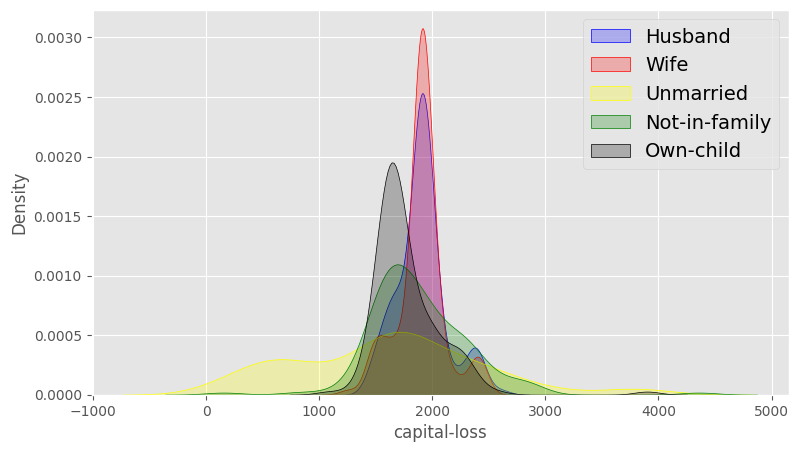

In [19]:
plt.figure(figsize=(9,5))
sns.kdeplot(groups.get('Husband'),fill=True,color='blue')
sns.kdeplot(groups.get('Wife'),fill=True,color='red')
sns.kdeplot(groups.get('Unmarried'),fill=True,color='yellow')
sns.kdeplot(groups.get('Not-in-family'),fill=True,color='green')
sns.kdeplot(groups.get('Own-child'),fill=True,color='black')
plt.legend(['Husband','Wife','Unmarried','Not-in-family', 'Own-child'],fontsize=14)
plt.show()

In [20]:
def multi_anova(groups,alpha=alpha):
    from itertools import combinations
    list_ = list(combinations(list(groups.keys()),2))
    
    for comb in list_:
        print(f'\n{comb[0]} и {comb[1]}:')
        _,p = st.ttest_ind(groups[comb[0]],groups[comb[1]])
        if p > alpha:
            print(f'Стьюдент: не можем отвергнуть H0 о равенстве средних {comb[0]} и {comb[1]}')
        else:
            print(f'Стьюдент: отвергаем H0 о равенстве средних {comb[0]} и {comb[1]}')
        
        _,p = st.f_oneway(groups[comb[0]],groups[comb[1]])
        if p > alpha:
            print(f'Фишер: не можем отвергнуть H0 о равенстве средних {comb[0]} и {comb[1]}')
        else:
            print(f'Фишер: отвергаем H0 о равенстве средних {comb[0]} и {comb[1]}')

In [21]:
multi_anova(groups)


Husband и Wife:
Стьюдент: не можем отвергнуть H0 о равенстве средних Husband и Wife
Фишер: не можем отвергнуть H0 о равенстве средних Husband и Wife

Husband и Unmarried:
Стьюдент: отвергаем H0 о равенстве средних Husband и Unmarried
Фишер: отвергаем H0 о равенстве средних Husband и Unmarried

Husband и Not-in-family:
Стьюдент: не можем отвергнуть H0 о равенстве средних Husband и Not-in-family
Фишер: не можем отвергнуть H0 о равенстве средних Husband и Not-in-family

Husband и Own-child:
Стьюдент: отвергаем H0 о равенстве средних Husband и Own-child
Фишер: отвергаем H0 о равенстве средних Husband и Own-child

Wife и Unmarried:
Стьюдент: отвергаем H0 о равенстве средних Wife и Unmarried
Фишер: отвергаем H0 о равенстве средних Wife и Unmarried

Wife и Not-in-family:
Стьюдент: не можем отвергнуть H0 о равенстве средних Wife и Not-in-family
Фишер: не можем отвергнуть H0 о равенстве средних Wife и Not-in-family

Wife и Own-child:
Стьюдент: отвергаем H0 о равенстве средних Wife и Own-child


In [22]:
st.f_oneway(groups.get('Husband'),
            groups.get('Wife'),
            groups.get('Unmarried'),
            groups.get('Not-in-family'),
            groups.get('Own-child'))

F_onewayResult(statistic=9.191835545829258, pvalue=3.183812019847509e-07)

**Выводы:**
1. Попарные тесты Стьюдента и Фишера показали одинаковый результат.
2. Подтверждены результаты предыдущего пункта о невозможности отказа от нулевой гипотезы для выборок Husband-Wife (равенство средних значений инвестиционных потерь).
3. Выявились дополнительные подтверждения нулевой гипотезы для выборок Husband и Not-in-family, Wife и Not-in-family и Not-in-family и Own-child.
***

### Построение точного и эфронова ДИ для выбранных метрик

In [23]:
# Определим функции, возвращающие требуемые ДИ

def mean_ci(r, alpha=0.05):
    """Точный доверительный интервал для среднего значения"""
    return sts.t.interval(1 - alpha, len(r)-1, loc=np.mean(r), scale=sts.sem(r))

def bootstrap_ci(r, type='mean', iter=1000, alpha=0.05):
    """Эфронов доверительный интервал"""
    r_list = []
    for i in range(iter + 1):
        r_ = np.random.choice(r, size=r.shape[0], replace=True)
        if type == 'mode':
            r_list.append(sts.mode(r_)[0])
        elif type == 'median':
            r_list.append(np.median(r_))
        elif type == 'var':
            r_list.append(np.var(r_))
        else:
            r_list.append(np.mean(r_))
    left, right = np.percentile(r_list, q=[round(alpha*50, 1), round(100 - alpha*50, 1)])
    return left, right

#### Метрика hours-per-week

In [24]:
# Средние значения рассматриваемых выборок метрики hours-per-week

groups = {
    'Husband': df.loc[df['relationship'] == 'Husband']['hours-per-week'],
    'Wife': df.loc[df['relationship'] == 'Wife']['hours-per-week'],
    'Unmarried': df.loc[df['relationship'] == 'Unmarried']['hours-per-week'],
    'Not-in-family': df.loc[df['relationship'] == 'Not-in-family']['hours-per-week'],
    'Own-child': df.loc[df['relationship'] == 'Own-child']['hours-per-week']
}

for key in groups.keys():
    print(f"{key}, mean: {groups[key].mean()}")

Husband, mean: 44.61068252437587
Wife, mean: 37.47776183644189
Unmarried, mean: 39.44256474519632
Not-in-family, mean: 41.03956588617331
Own-child, mean: 33.32085722909749


In [25]:
# Границы точного и эфронова ДИ

print(f"Mean CI: {mean_ci(df['hours-per-week'])}")
print(f"Bootstrap CI: {bootstrap_ci(df['hours-per-week'], type='mean')}")

Mean CI: (40.82734490281174, 41.04868888605208)
Bootstrap CI: (40.83357657777188, 41.04659236654726)


In [26]:
for key in groups.keys():
    pvalue = st.ttest_1samp(groups[key], popmean=df['hours-per-week'].mean()).pvalue
    if pvalue > alpha:
        print(f'Не можем отвергнуть H0 о равенстве средних выборки {key} и генеральной совокупности')
    else:
        print(f'Отвергаем H0 о равенстве средних выборки {key} и генеральной совокупности')

Отвергаем H0 о равенстве средних выборки Husband и генеральной совокупности
Отвергаем H0 о равенстве средних выборки Wife и генеральной совокупности
Отвергаем H0 о равенстве средних выборки Unmarried и генеральной совокупности
Не можем отвергнуть H0 о равенстве средних выборки Not-in-family и генеральной совокупности
Отвергаем H0 о равенстве средних выборки Own-child и генеральной совокупности


Наблюдаем соответствие теста Стьюдента и нахождения среднего выборки Not-in-family внутри границ доверительного интервала

#### Метрика capital-gain

In [27]:
# Средние значения рассматриваемых выборок метрики capital-gain

groups = {
    'Husband': df_capital_gain.loc[df_capital_gain['relationship'] == 'Husband']['capital-gain'],
    'Wife': df_capital_gain.loc[df_capital_gain['relationship'] == 'Wife']['capital-gain'],
    'Unmarried': df_capital_gain.loc[df_capital_gain['relationship'] == 'Unmarried']['capital-gain'],
    'Not-in-family': df_capital_gain.loc[df_capital_gain['relationship'] == 'Not-in-family']['capital-gain'],
    'Own-child': df_capital_gain.loc[df_capital_gain['relationship'] == 'Own-child']['capital-gain']
}

for key in groups.keys():
    print(f"{key}, mean: {groups[key].mean()}")

Husband, mean: 14793.843889384478
Wife, mean: 13147.476377952757
Unmarried, mean: 8791.210116731518
Not-in-family, mean: 12079.853875476492
Own-child, mean: 6204.910447761194


In [28]:
# Границы точного и эфронова ДИ

print(f"Mean CI: {mean_ci(df_capital_gain['capital-gain'])}")
print(f"Bootstrap CI: {bootstrap_ci(df_capital_gain['capital-gain'], type='mean')}")

Mean CI: (12420.024933002915, 13864.346043250385)
Bootstrap CI: (12408.42321899736, 13910.894986807389)


In [29]:
for key in groups.keys():
    pvalue = st.ttest_1samp(groups[key], popmean=df_capital_gain['capital-gain'].mean()).pvalue
    if pvalue > alpha:
        print(f'Не можем отвергнуть H0 о равенстве средних выборки {key} и генеральной совокупности')
    else:
        print(f'Отвергаем H0 о равенстве средних выборки {key} и генеральной совокупности')

Отвергаем H0 о равенстве средних выборки Husband и генеральной совокупности
Не можем отвергнуть H0 о равенстве средних выборки Wife и генеральной совокупности
Отвергаем H0 о равенстве средних выборки Unmarried и генеральной совокупности
Не можем отвергнуть H0 о равенстве средних выборки Not-in-family и генеральной совокупности
Отвергаем H0 о равенстве средних выборки Own-child и генеральной совокупности


Наблюдаем соответствие теста Стьюдента и нахождения среднего выборок Wife и Not-in-family внутри границ доверительного интервала

#### Метрика capital-loss

In [30]:
# Средние значения рассматриваемых выборок метрики capital-loss

groups = {
    'Husband': df_capital_loss.loc[df_capital_loss['relationship'] == 'Husband']['capital-loss'],
    'Wife': df_capital_loss.loc[df_capital_loss['relationship'] == 'Wife']['capital-loss'],
    'Unmarried': df_capital_loss.loc[df_capital_loss['relationship'] == 'Unmarried']['capital-loss'],
    'Not-in-family': df_capital_loss.loc[df_capital_loss['relationship'] == 'Not-in-family']['capital-loss'],
    'Own-child': df_capital_loss.loc[df_capital_loss['relationship'] == 'Own-child']['capital-loss']
}

for key in groups.keys():
    print(f"{key}, mean: {groups[key].mean()}")

Husband, mean: 1912.9376558603492
Wife, mean: 1896.5859375
Unmarried, mean: 1626.2446043165467
Not-in-family, mean: 1860.1958762886597
Own-child, mean: 1773.3175675675675


In [31]:
# Границы точного и эфронова ДИ

print(f"Mean CI: {mean_ci(df_capital_loss['capital-loss'])}")
print(f"Bootstrap CI: {bootstrap_ci(df_capital_loss['capital-loss'], type='mean')}")

Mean CI: (1857.1197219893288, 1887.2372873564655)
Bootstrap CI: (1857.476168224299, 1888.7093457943924)


In [32]:
for key in groups.keys():
    pvalue = st.ttest_1samp(groups[key], popmean=df_capital_loss['capital-loss'].mean()).pvalue
    if pvalue > alpha:
        print(f'Не можем отвергнуть H0 о равенстве средних выборки {key} и генеральной совокупности')
    else:
        print(f'Отвергаем H0 о равенстве средних выборки {key} и генеральной совокупности')

Отвергаем H0 о равенстве средних выборки Husband и генеральной совокупности
Не можем отвергнуть H0 о равенстве средних выборки Wife и генеральной совокупности
Отвергаем H0 о равенстве средних выборки Unmarried и генеральной совокупности
Не можем отвергнуть H0 о равенстве средних выборки Not-in-family и генеральной совокупности
Отвергаем H0 о равенстве средних выборки Own-child и генеральной совокупности


Наблюдаем соответствие теста Стьюдента и нахождения среднего выборок Wife и Not-in-family внутри границ доверительного интервала
***

### Возможность использования в п.2 других статистических тестов

Проведенное исследование показало, что данные в выбранном датасете имеют, зачастую, распределение, отличное от нормального. Соответственно, при выборе дополнительных статистических тестов стоит ориентироваться, в первую очередь, на непараметрические тесты (либо подумать в сторону преобразования данных), а именно:
- тест Вилкоксона (непараметрических аналог парного критерия Стьюдента) - для сравнения двух независимых выборок, распределение которых отличается от нормального;
- точный критерий Фишера - для работы с категориальными параметрами: можно посмотреть, насколько случайно распределены значения между сегментами или имеется значимый перевес;
- тест Хи-квадрат - для поиска взаимосвязи между сегментами (категориальными переменными).